In [1]:
import tensorflow as tf
print (tf.__version__)

2.3.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [5]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip','r') as z:
  z.extractall()

In [7]:
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
img_rows=224
img_cols=224
channels=3

In [9]:
from tqdm import tqdm
import cv2
features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for rgb
  train_img_resize = cv2.resize(train_img, (img_rows,img_cols))
  features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:38<00:00, 263.81it/s]


In [ ]:
plt.imshow(features[0])
print (label[0])

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label, random_state=42)

In [12]:
x_train=np.array(x_train)
x_test=np.array(x_test)

In [13]:
print('Trainig features:',x_train.shape)
print('Testing features:',x_test.shape)

Trainig features: (7155, 224, 224, 3)
Testing features: (3067, 224, 224, 3)


In [14]:
print('Trainig labels:',y_train.shape)
print('Testing labels:',y_test.shape)

Trainig labels: (7155,)
Testing labels: (3067,)


In [15]:
def preprocess_input(x):
  return tf.keras.applications.vgg16.preprocess_input(x)

In [ ]:
def preprocess_input(x):
  return tf.keras.applications.resnet50.preprocess_input(x)

In [21]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         #featurewise_center=True,
                                                         rescale=1./255,
                                                         rotation_range=30,
                                                         #shear_range=0.2,
                                                         #zoom_range=0.3,
                                                         horizontal_flip=True,
                                                         vertical_flip=True)

In [23]:
valgen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


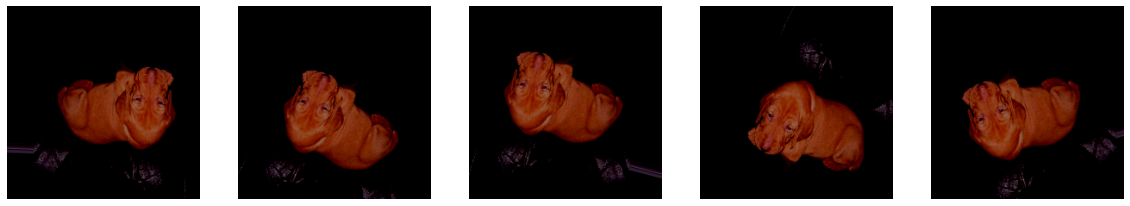

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
gen = datagen.flow(x_train[4:5], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

In [24]:
y_train = tf.keras.utils.to_categorical(y_train, 120)
y_test = tf.keras.utils.to_categorical(y_test, 120)

In [25]:
train_generator = datagen.flow(x_train,y_train,batch_size=64,seed=42)
val_generator = valgen.flow(x_test,y_test,batch_size=64,seed=42)

In [37]:
base_model = tf.keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(img_rows,img_cols,channels),
                                         pooling='max')
for layers in base_model.layers:
  layers.trainable=False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(img_rows,img_cols,channels),
                                            pooling='max')
for layers in base_model.layers:
  layers.trainable=False
base_model.summary()

In [38]:
x=base_model.output
x=tf.keras.layers.Dense(120,activation='softmax')(x) 
model=tf.keras.Model(inputs=base_model.input,outputs=x)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [39]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_acc',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    steps_per_epoch= len(x_train)//64,  #Number of training images//batch_size
                    #validation_data=(x_test,y_test),
                    validation_data=val_generator,
                    validation_steps = len(x_test)//64, #Number of test images//batch_size
                    callbacks = [model_checkpoint,model_es,model_lr])

Epoch 1/5
111/111 [==============================] - 5175s 47s/step - loss: 4.9335 - accuracy: 0.0172 - val_loss: 136.1712 - val_accuracy: 0.0223
Epoch 2/5
111/111 [==============================] - 5155s 46s/step - loss: 4.5686 - accuracy: 0.0391 - val_loss: 136.8397 - val_accuracy: 0.0512
Epoch 3/5
111/111 [==============================] - 5142s 46s/step - loss: 4.3462 - accuracy: 0.0653 - val_loss: 131.3288 - val_accuracy: 0.0755
Epoch 4/5
 38/111 [=========>....................] - ETA: 39:09 - loss: 4.1700 - accuracy: 0.0962

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()